In [1]:
import pandas as pd

tcga_file="/data/sr933/Bulk RNA/TCGA Bulk RNA/TCGA.KIRC.sampleMap_HiSeqV2.gz"
tcga_df=pd.read_csv(tcga_file, sep="\t")
target_df = pd.read_csv('/home/sr933/rcc/4_network_analysis/data/key_proteins_muanually_filtered.txt')



# Target genes

In [2]:
filtered_tcga_df = tcga_df[tcga_df["sample"].isin(target_df["Gene"])]
# Identify items in `target_df["Gene"]` not in `tcga_df["sample"]`
missing_items = set(target_df["Gene"]) - set(filtered_tcga_df["sample"])

# Print the missing items
print("Items in target_df['Gene'] not in filtered tcga_df['sample']:", missing_items)

Items in target_df['Gene'] not in filtered tcga_df['sample']: set()


In [3]:
import umap
import matplotlib.pyplot as plt
import numpy as np
labels=list(tcga_df.columns[1:])
y_test = ["Tumor" if '-01' in val else "Benign" for val in labels]
X_test = filtered_tcga_df.iloc[:, 1:].to_numpy().T
#X_combined=filtered_X_data.to_numpy().T
#y_data=filtered_X_data.columns
# Assuming X_combined and y_labels are already loaded
# Check the shape of the data
#print("Shape of X_combined:", X_combined.shape)
#print("Shape of y_labels:", len(y_data))

# Step 1: Initialize and fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, random_state=42)

# Step 2: Transform the data
X_umap = reducer.fit_transform(X_test)

/home/sr933/miniconda3/envs/rcc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sr933/miniconda3/envs/rcc/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


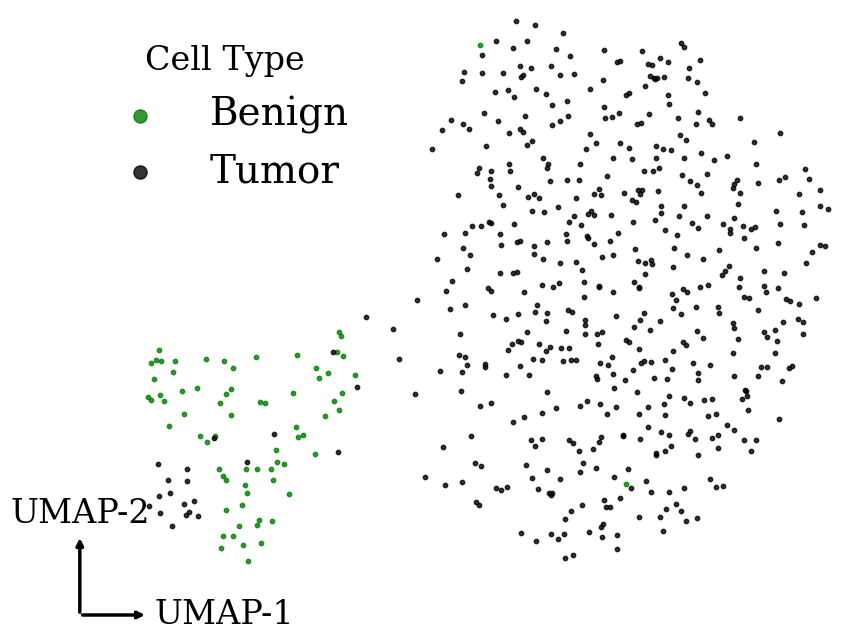

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot styling for publication
params = {
    "ytick.color": "black",
    "xtick.color": "black",
    "axes.labelcolor": "black",
    "axes.edgecolor": "black",
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
}
plt.rcParams.update(params)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Define class labels and color
targets = sorted(set(y_test))  # Typically: ['Benign', 'Tumor']
for target in targets:
    color = "k" if target == "Tumor" else "green"
    mask = np.array(y_test) == target
    ax.scatter(
        X_umap[mask, 0],
        X_umap[mask, 1],
        c=color,
        label=target,
        s=10,
        alpha=0.8
    )

# Legend
ax.legend(
    title="Cell Type",
    fontsize=28,
    title_fontsize=24,
    loc='upper left', 
    markerscale=3,
    frameon=False
)

# Remove axis box
ax.axis("off")

# UMAP arrow configuration
min_x, min_y = X_umap[:, 0].min(), X_umap[:, 1].min()
range_x = X_umap[:, 0].max() - min_x
range_y = X_umap[:, 1].max() - min_y

arrow_len_x = 0.1 * range_x
arrow_len_y = 0.1 * range_x  # uniformity

x_pad = 0.1 * range_x
y_pad = 0.1 * range_y
arrow_base_x = min_x - x_pad
arrow_base_y = min_y - y_pad

# Draw axis arrows
ax.annotate("", xy=(arrow_base_x + arrow_len_x, arrow_base_y), xytext=(arrow_base_x, arrow_base_y),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2.5))
ax.annotate("", xy=(arrow_base_x, arrow_base_y + arrow_len_y), xytext=(arrow_base_x, arrow_base_y),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2.5))

# Axis labels
ax.text(arrow_base_x + arrow_len_x + 0.01 * range_x, arrow_base_y, "UMAP-1", fontsize=24, ha="left", va="center")
ax.text(arrow_base_x, arrow_base_y + arrow_len_y + 0.01 * range_y, "UMAP-2", fontsize=24, ha="center", va="bottom")

# Adjust limits so arrows are visible
ax.set_xlim(arrow_base_x - 0.02 * range_x, X_umap[:, 0].max() + 0.02 * range_x)
ax.set_ylim(arrow_base_y - 0.02 * range_y, X_umap[:, 1].max() + 0.02 * range_y)

# Save figure
save_path = "/home/sr933/output/umap_tcga_drug_targets.png"
plt.savefig(save_path, format="png", bbox_inches="tight", dpi=900)
plt.show()


# Czech datset

In [5]:
import os
import pandas as pd

# Define the folder containing the .txt.gz files
folder_path = '/data/sr933/Bulk RNA/GSE167093'



# Initialize an empty list to store DataFrames
processed_dfs = []

# Loop over all .txt.gz files in the folder
for file_name in os.listdir(folder_path):
    
    
       
            file_path = os.path.join(folder_path, file_name)
            
            # Load the file into a DataFrame
            if file_name=="GSE167093_non_norm_matrix13.txt":
                df = pd.read_csv(file_path, sep='\t')
            else:
                df = pd.read_csv(file_path, sep='\t', compression='gzip')
            
            # Step 1: Group by 'TargetID' and calculate the mean for numeric columns
            if 'TargetID' in df.columns:
                group_column = 'TargetID'
            else:
                # Use the first column if 'TargetID' is not found
                group_column = df.columns[0]
            print(df.shape)
            # Step 1: Group by the identified column and calculate the mean
            df_grouped = df.groupby(group_column).median()
            
            # Step 2: Filter for columns containing "AVG" in their names
            avg_columns = [col for col in df_grouped.columns if 'AVG' in col]
            df_filtered = df_grouped[avg_columns]
            
            # Step 3: Filter for rows where 'TargetID' is in the target_gene_list
            df_filtered = df_filtered[df_filtered.index.isin(target_df["Gene"])]
            print(df_filtered.shape)
            # Add the processed DataFrame to the list
            processed_dfs.append(df_filtered)
        
# Concatenate all processed DataFrames into one final DataFrame
final_df = pd.concat(processed_dfs)

# Reset index if needed (optional)

final_df = final_df.groupby("TargetID").median()

# Reset index if needed (optional)
final_df.reset_index(inplace=True)
# Save the final concatenated DataFrame to a CSV file (optional)







(47214, 62)
(16, 30)
(47179, 516)
(16, 257)
(47202, 72)
(16, 35)
(47217, 66)
(16, 32)
(47204, 54)
(16, 26)
(47223, 72)
(16, 35)
(47214, 54)
(16, 26)
(47219, 54)
(16, 26)
(47216, 44)
(16, 21)
(47213, 46)
(16, 22)
(47206, 54)
(16, 26)
(47222, 64)
(16, 31)
(47205, 180)
(16, 89)


In [6]:


reducer = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, random_state=42)
final_df2 = final_df.drop("TargetID", axis=1)
labels = ["Tumor" if "TU" in col else "Benign" for col in final_df2.columns]
# Step 2: Transform the data
X_umap = reducer.fit_transform(final_df2.to_numpy().T)

/home/sr933/miniconda3/envs/rcc/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


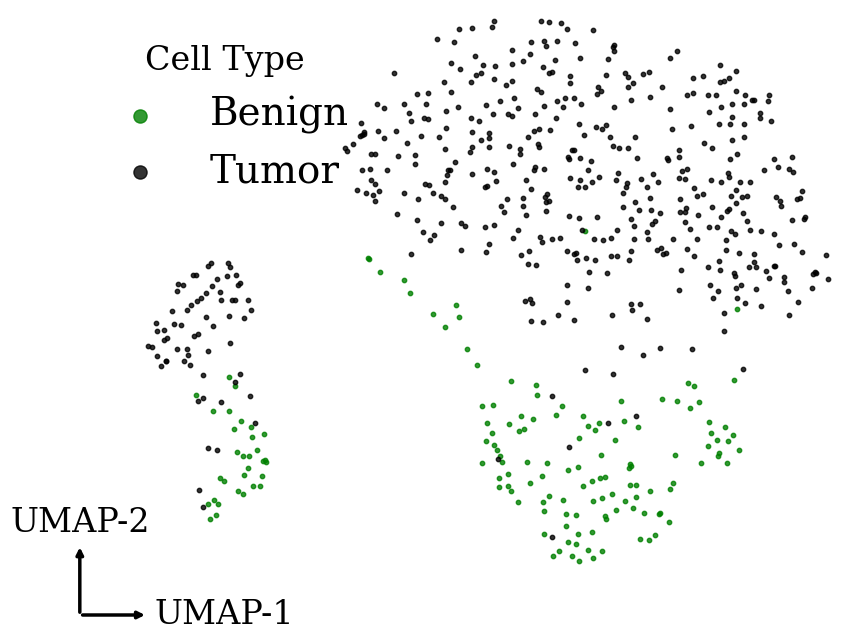

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot styling
params = {
    "ytick.color": "black",
    "xtick.color": "black",
    "axes.labelcolor": "black",
    "axes.edgecolor": "black",
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
}
plt.rcParams.update(params)

# Initialize figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot tumor and benign
targets = sorted(set(labels))  # Typically ['Benign', 'Tumor']
for target in targets:
    color = "k" if target == "Tumor" else "green"
    mask = np.array(labels) == target
    ax.scatter(
        X_umap[mask, 0],
        X_umap[mask, 1],
        c=color,
        label=target,
        s=10,
        alpha=0.8
    )

# Legend formatting
ax.legend(
    title="Cell Type",
    fontsize=28,
    title_fontsize=24,
    loc='upper left', 
    markerscale=3,
    frameon=False
)

# Remove axis box
ax.axis("off")

# Bottom-left arrow setup
min_x, min_y = X_umap[:, 0].min(), X_umap[:, 1].min()
range_x = X_umap[:, 0].max() - min_x
range_y = X_umap[:, 1].max() - min_y

arrow_len_x = 0.1 * range_x
arrow_len_y = 0.1 * range_x

x_pad = 0.1 * range_x
y_pad = 0.1 * range_y
arrow_base_x = min_x - x_pad
arrow_base_y = min_y - y_pad

# Draw arrows
ax.annotate("", xy=(arrow_base_x + arrow_len_x, arrow_base_y), xytext=(arrow_base_x, arrow_base_y),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2.5))
ax.annotate("", xy=(arrow_base_x, arrow_base_y + arrow_len_y), xytext=(arrow_base_x, arrow_base_y),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2.5))

# Axis labels
ax.text(arrow_base_x + arrow_len_x + 0.01 * range_x, arrow_base_y, "UMAP-1", fontsize=24, ha="left", va="center")
ax.text(arrow_base_x, arrow_base_y + arrow_len_y + 0.01 * range_y, "UMAP-2", fontsize=24, ha="center", va="bottom")

# Expand limits to include arrows
ax.set_xlim(arrow_base_x - 0.02 * range_x, X_umap[:, 0].max() + 0.02 * range_x)
ax.set_ylim(arrow_base_y - 0.02 * range_y, X_umap[:, 1].max() + 0.02 * range_y)

# Save the figure
save_path = "/home/sr933/output/umap_czech_drug_targets.png"
plt.savefig(save_path, format="png", bbox_inches="tight", dpi=900)
plt.show()
